In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys, warnings
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

from importlib import reload

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainutils, datasource, augments

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

warnings.filterwarnings('ignore', '.*output shape of zoom.*') # turn off stupid zoom warning

imwidth = 256
imheight = 256
numimgs = 100

In [2]:
dataset=[trainutils.createTestImage(imwidth,imheight,noiseMax=0.8) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

In [3]:
dsrc=datasource.DataSource(imgin,maskin)

%timeit dsrc.getIndexBatch(np.arange(numimgs))
%timeit dsrc.getRandomBatch(numimgs)

19.7 ms ± 640 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19 ms ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


28.1 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


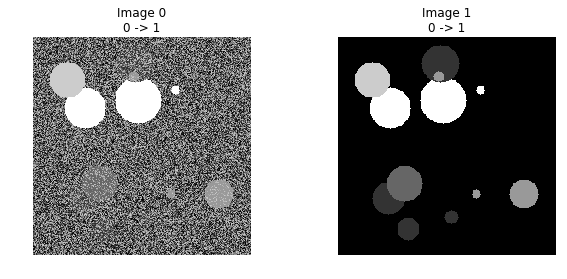

In [4]:
augs=[
    augments.rot90, augments.transpose, augments.flip,
]

dsrc=datasource.DataSource(imgin,maskin,augments=augs)

with dsrc.threadBatchGen(numimgs) as gen:
    %timeit gen()
    imgs,segs=gen()
    f,a=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

46 ms ± 837 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


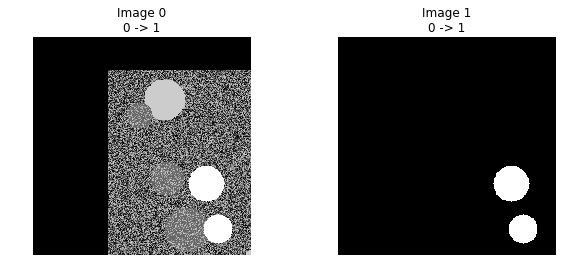

In [13]:
augs=[
    partial(augments.shift,prob=1.0,nonzeroIndex=1)
]

dsrc=datasource.DataSource(imgin,maskin==maskin.max(),augments=augs)

with dsrc.threadBatchGen(numimgs) as gen:
    %timeit gen()
    imgs,segs=gen()
    f,a=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

207 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


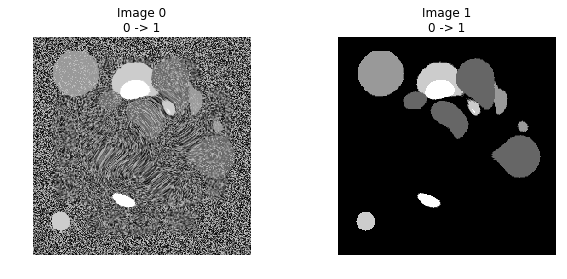

In [6]:
augs=[
    partial(augments.deformPIL,prob=1.0)
]

dsrc=datasource.DataSource(imgin,maskin,augments=augs)

with dsrc.threadBatchGen(numimgs) as gen:
    %timeit gen()
    imgs,segs=gen()
    f,a=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

85.6 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


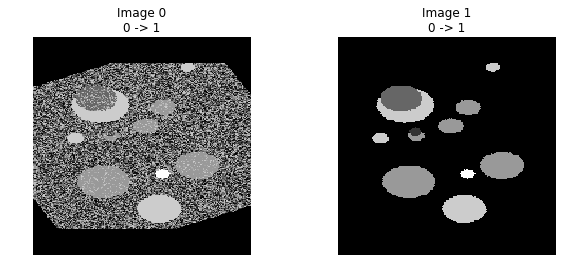

In [7]:
augs=[
    partial(augments.rotateZoomPIL,prob=1.0)
]

dsrc=datasource.DataSource(imgin,maskin,augments=augs)

with dsrc.threadBatchGen(numimgs) as gen:
    %timeit gen()
    imgs,segs=gen()
    f,a=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

In [8]:
datasource=reload(datasource)
augments=reload(augments)

augs=[
    lambda i,m:(i,m.astype(np.float32)),
    augments.rot90, augments.transpose, augments.flip,
    augments.deformPIL,
    augments.rotateZoomPIL,
    augments.shift,
]

dsrc=datasource.DataSource(imgin,maskin,augments=augs)

with dsrc.threadBatchGen(numimgs) as gen:
    imgs,masks=gen()
    %timeit gen()

print(imgs.shape,masks.shape)
#trainutils.viewVolumeJupyter(np.dstack([imgs[...,0],masks]),(12,6))

177 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(100, 256, 256, 1) (100, 256, 256)
